In [67]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scienceplots
import scipy
from tqdm import tqdm
import scipy.stats
plt.style.use(['science', 'grid'])
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from scipy.ndimage import gaussian_filter
from pathlib import Path
from scipy.optimize import curve_fit
from scipy import ndimage, misc
from scipy.stats import t

plt.rcParams["figure.figsize"] = (3.5, 2.5)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["lines.linewidth"] = 0.5

In [68]:
folder = "optotune"
files = os.listdir(folder)
files.sort(key=lambda x: os.path.getctime(os.path.join(folder, x)))      
# files = files[1000::] 

In [69]:
class sample:
    def __init__(self, filename):
        properties = filename[0:-4].split("_")
        self.filename = filename
        self.number = int(properties[0])
        self.time = float(properties[1])
        self.command = float(properties[2])
        self.temperature = float(properties[3])
        self.pressure = float(properties[4])
        self.a_x = float(properties[5])
        self.a_y = float(properties[6])
        self.a_z = float(properties[7])
        self.a = np.sqrt(self.a_x ** 2 + self.a_y ** 2 + self.a_z ** 2)
        self.g_x = float(properties[8])
        self.g_y = float(properties[9])
        self.g_z = float(properties[10])
        self.m_x = float(properties[11])
        self.m_y = float(properties[12])
        self.m_z = float(properties[13])
        
    def load(self):
#         print(self.filename)
        return np.load(os.path.join(folder, self.filename))['arr_0']#[AOI_Y - AOI_SIZE:AOI_Y + AOI_SIZE,AOI_X - AOI_SIZE:AOI_X + AOI_SIZE]

    def load_thresholded(self, threshold=128):
        img = self.load()
        img[img <= threshold] = 0
        return img
    
    def spot_area(self):
        img = self.load()
        return np.sum(img > 8) # arbitrarily chosen
    
    def __repr__(self):
        return (f"n: {self.number} t: {self.time} cmd: {self.command} temp: {self.temperature} p: {self.pressure} a: {self.a}")

    def com(self):
        return ndimage.measurements.center_of_mass(self.load_thresholded())
        
    def airy_encircled_energy(self, img_thresh = 0.25):
        def encircled_energy(data, max_energy, x_centroid, y_centroid, radius):
            """
            Compute the encircled energy within a given radius around a centroid in a 2D numpy array.
            Uses Gaussian blur for anti-aliasing.
            """
            
            # Generate coordinate grid
            y, x = np.ogrid[:data.shape[0], :data.shape[1]]
            
            # Compute the distance from the centroid for each element in the array
            dist_from_centroid = np.sqrt((x - x_centroid)**2 + (y - y_centroid)**2)
            
            # Create a binary mask with pixels inside the circle
            mask = (dist_from_centroid <= radius).astype(float)
            
            # Apply Gaussian blur for anti-aliasing
            mask_blurred = gaussian_filter(mask, sigma=1)
            
            # Compute and return the total energy within the blurred circle
            return np.sum(data * mask_blurred)/max_energy
            
        threshold = 0.838
        max_iter = 100
        
        img = np.squeeze(self.load())
        img[img <= img_thresh * np.max(img)] = 0
        
        max_energy = np.sum(img)
        centroid = ndimage.measurements.center_of_mass(img)
        
        pos_bound = img.shape[0]
        neg_bound = 1
        iter = 0

        while(np.abs(pos_bound - neg_bound) > 1 or iter == max_iter):
            mid_bound = (pos_bound + neg_bound)/2
            energy = encircled_energy(img, max_energy, centroid[1], centroid[0], mid_bound)

            if(energy < threshold):
                neg_bound = mid_bound
            else:
                pos_bound = mid_bound

            iter += 1

        if(iter == max_iter):
            print("Hit max iter")
            return -1
        
        energy_pos = encircled_energy(img, max_energy, centroid[1], centroid[0], pos_bound)
        energy_neg = encircled_energy(img, max_energy, centroid[1], centroid[0], neg_bound)

        return neg_bound + (((pos_bound - neg_bound)/(energy_pos - energy_neg)) * (threshold - energy_neg))
        
def plot_sample(sample):
    plt.imshow(ndimage.rotate(sample.load(), 23.6 + 180))

In [70]:
samples = [sample(x) for x in files]
t0 = samples[0].time

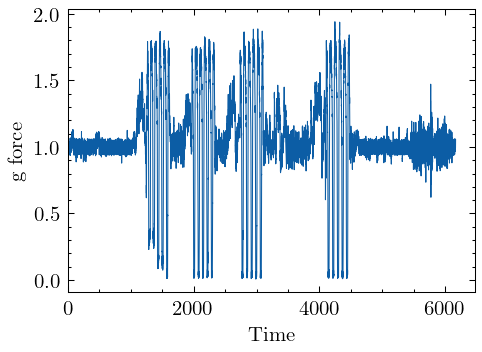

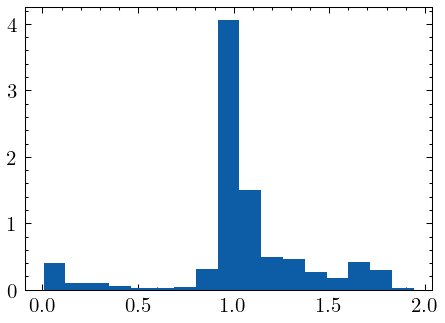

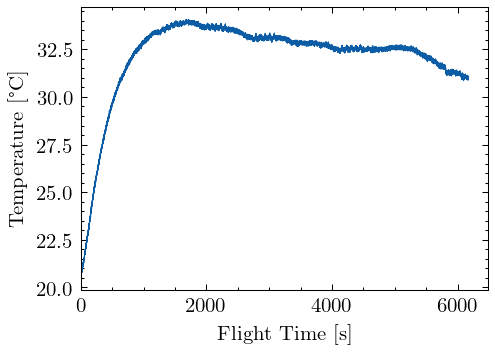

In [267]:
# print some acceleration data just so we know
accel_sample = list(map(lambda x: x.time - t0, samples))
accel = list(map(lambda x: x.a, samples))
plt.plot(accel_sample, accel)
plt.xlabel('Time')
plt.xlim(0)
plt.grid()
plt.ylabel('g force')
plt.show()
plt.hist(accel, density=True, bins=17)
plt.grid()
plt.show()
plt.plot([x.time - t0 for x in samples], [x.temperature for x in samples])
plt.grid()
plt.ylabel("Temperature [°C]")
plt.xlabel("Flight Time [s]")
plt.xlim(0)
plt.show()


# np.save("time_optotune.npy", [x.time - t0 for x in samples])
# np.save("temp_optotune.npy", [x.temperature for x in samples])

In [71]:
samples_0g = [x for x in samples if x.a < 0.3]
samples_1g = [x for x in samples if x.a < 1.1 and x.a > 0.9]
samples_hg = [x for x in samples if x.a > 1.5]

In [9]:
# plt.plot(list(map(lambda x: x.time, samples)), list(map(lambda x: x.pressure, samples)))

cmds_0g = [x.command for x in samples_0g]
spots_0g = [x.spot_area() for x in samples_0g]

cmds_hg = [x.command for x in samples_hg]
spots_hg = [x.spot_area() for x in samples_hg]

cmds_1g = [x.command for x in samples_1g]
spots_1g = [x.spot_area() for x in samples_1g]


KeyboardInterrupt: 

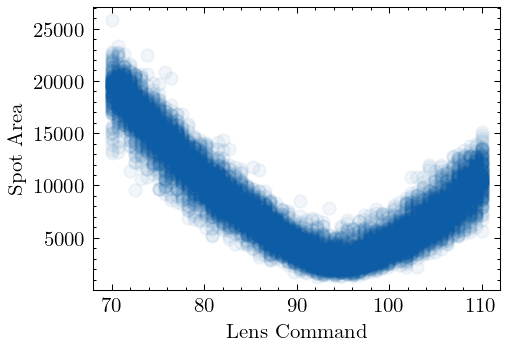

In [8]:
# plt.scatter(cmds_0g, spots_0g, alpha=0.4)
# plt.scatter(cmds_hg, spots_hg, alpha=0.4)
plt.scatter(cmds_1g, spots_1g, alpha=0.05)
plt.xlabel('Lens Command')
plt.ylabel('Spot Area')
plt.grid()
plt.show()

0g: 0, 1g: 5, hg: 0


c:\users\shree\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\shree\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


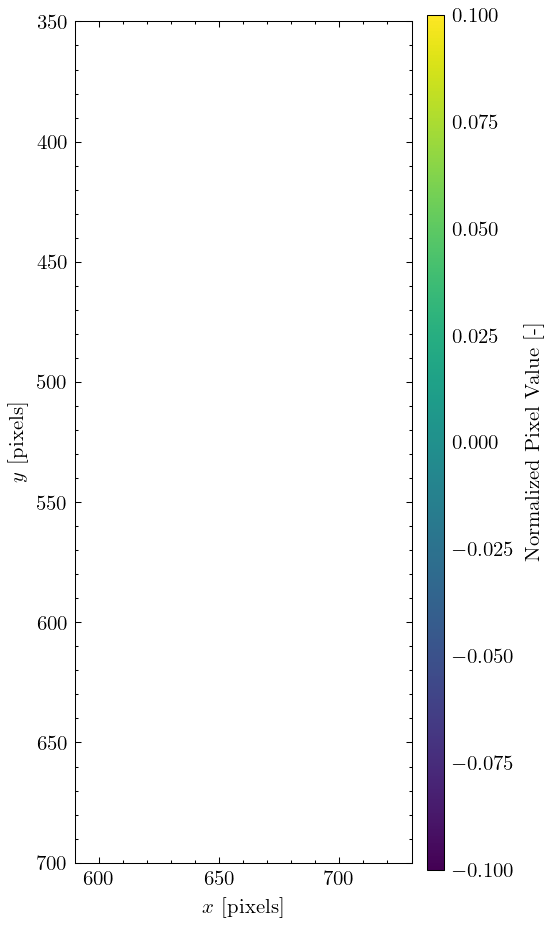

In [72]:
# image_1g = samples_1g[500].load()

focal_cmd = 94.76
focal_cmds = np.unique([x.command for x in samples_0g])
#[ 70.    70.63  71.27  71.9   72.54  73.17  73.81  74.44  75.08  75.71
#  76.35  76.98  77.62  78.25  78.89  79.52  80.16  80.79  81.43  82.06
#  82.7   83.33  83.97  84.6   85.24  85.87  86.51  87.14  87.78  88.41
#  89.05  89.68  90.32  90.95  91.59  92.22  92.86  93.49  94.13  94.76
#  95.4   96.03  96.67  97.3   97.94  98.57  99.21  99.84 100.48 101.11
# 101.75 102.38 103.02 103.65 104.29 104.92 105.56 106.19 106.83 107.46
# 108.1  108.73 109.37 110.  ]
focal_samples_1g = [x for x in samples_1g if x.command == focal_cmd]
focal_samples_0g = [x for x in samples_0g if x.command == focal_cmd]
focal_samples_hg = [x for x in samples_hg if x.command == focal_cmd]
print(f"0g: {len(focal_samples_0g)}, 1g: {len(focal_samples_1g)}, hg: {len(focal_samples_hg)}")

img = (np.mean([x.load() for x in focal_samples_0g], 0) + np.mean([x.load() for x in focal_samples_hg], 0) +np.mean([x.load() for x in focal_samples_1g], 0))
img = ndimage.rotate(img, 23.6 + 180)
img = img/np.max(img)
plt.figure(figsize=(3.25, 6))
plt.imshow(img)
# plt.axis('equal')
plt.tight_layout()
plt.xlim(570+20, 750-20)
plt.ylim(700, 350)
cb1 = plt.colorbar(fraction=0.1, pad=0.04, aspect=50)
cb1.set_label("Normalized Pixel Value [-]")
plt.grid()
plt.xlabel("$x$ [pixels]")
plt.ylabel("$y$ [pixels]")
plt.savefig("optotune_zerog_spots.png", dpi=600)
plt.show()

OSError: [Errno 22] Invalid argument: 'opto_spots_all.pdf'

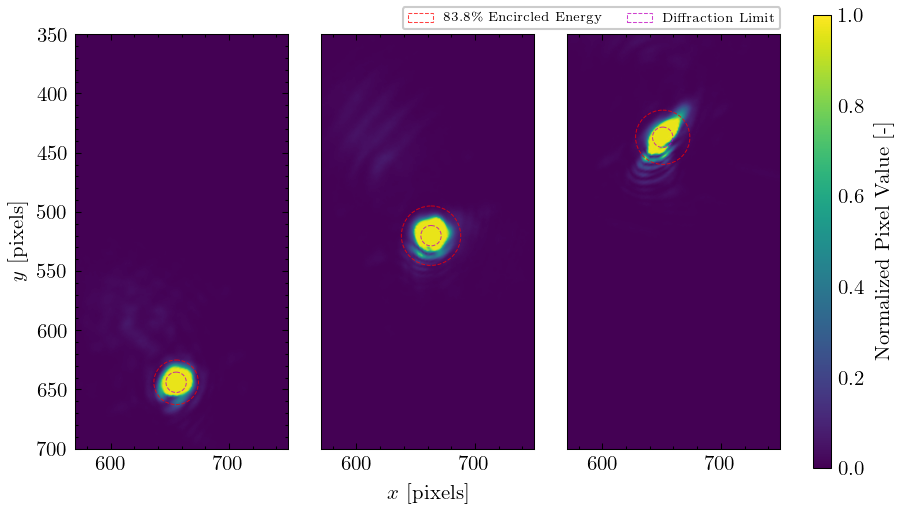

In [60]:
efl=120e-3
# spot_sample_n = 3
def plot_airy_encircled_energy(data, x0, y0, radius, ax = None, **kwargs):
    ellipse = matplotlib.patches.Ellipse((x0, y0), 2*radius, 2*radius, angle=0, edgecolor='red', facecolor='none', linestyle='dashed', **kwargs)
    if(ax is None):
        ax = plt.gca()
        
    ax.add_patch(ellipse)

def plot_diffraction_limit(data, x0, y0, ax = None, **kwargs):
    diameter = (4 * 633e-9 * efl)/(2.5e-3 * np.pi * 2.25e-6)
    ellipse = matplotlib.patches.Ellipse((x0, y0), diameter, diameter, angle=0, edgecolor='m', facecolor='none', linestyle='dashed', **kwargs)
    if(ax is None):
        ax = plt.gca()
        
    ax.add_patch(ellipse)

fig, axs = plt.subplots(1, 4, sharex=False, sharey=False, width_ratios=[6, 6, 6, 0.5], figsize=(6.5, 4))

spot_sample = focal_samples_0g[3]
spot_img = spot_sample.load()
spot_img = ndimage.rotate(spot_img, 23.6 + 180)
spot_img_threshold = spot_img.copy()
spot_img_threshold[spot_img_threshold <= 16] = 0 # tiny threshold to avoid far-away noise residuals
centroid_y0, centroid_x0, _ = ndimage.center_of_mass(spot_img_threshold)
airy_radius = spot_sample.airy_encircled_energy(img_thresh=0.025)

# plt.axis("equal")
# First subplot
ax = axs[0]
ax.imshow(spot_img/np.max(spot_img), interpolation='bicubic')
plot_airy_encircled_energy(spot_img, centroid_x0, centroid_y0, airy_radius, ax, alpha=0.75, linewidth=0.5)
plot_diffraction_limit(spot_img, centroid_x0, centroid_y0, ax, alpha=0.75, linewidth=0.5)
# ax.axis('equal')
ax.set_xlim(570, 750)
ax.set_ylim(700, 350)
ax.grid()
# ax.set_xlabel("$x$ [pixels]")
ax.set_ylabel("$y$ [pixels]")
# plt.savefig("spot_opto_0g.pdf")

# Second subplot
spot_sample = focal_samples_1g[4]
spot_img = spot_sample.load()
spot_img = ndimage.rotate(spot_img, 23.6 + 180)
spot_img_threshold = spot_img.copy()
spot_img_threshold[spot_img_threshold <= 16] = 0  # tiny threshold to avoid far-away noise residuals
centroid_y0, centroid_x0, _ = ndimage.center_of_mass(spot_img_threshold)
airy_radius = spot_sample.airy_encircled_energy(img_thresh=0.025)

ax = axs[1]
ax.imshow(spot_img/np.max(spot_img), interpolation='bicubic')
plot_airy_encircled_energy(spot_img, centroid_x0, centroid_y0, airy_radius, ax, alpha=0.75, linewidth=0.5)
plot_diffraction_limit(spot_img, centroid_x0, centroid_y0, ax, alpha=0.75, linewidth=0.5)
# ax.axis('equal')
ax.set_xlim(570, 750)
ax.set_ylim(700, 350)
ax.set_yticks([])
ax.grid()
ax.set_xlabel("$x$ [pixels]")
# ax.set_ylabel("$y$ [pixels]")
# plt.savefig("spot_opto_1g.pdf")

# Third subplot
spot_sample = focal_samples_hg[5]
spot_img = spot_sample.load()
spot_img = ndimage.rotate(spot_img, 23.6 + 180)
spot_img_threshold = spot_img.copy()
spot_img_threshold[spot_img_threshold <= 16] = 0  # tiny threshold to avoid far-away noise residuals
centroid_y0, centroid_x0, _ = ndimage.center_of_mass(spot_img_threshold)
airy_radius = spot_sample.airy_encircled_energy(img_thresh=0.025)

ax = axs[2]
ax.imshow(spot_img/np.max(spot_img), interpolation='bicubic')
plot_airy_encircled_energy(spot_img, centroid_x0, centroid_y0, airy_radius, ax, alpha=0.75, linewidth=0.5)
plot_diffraction_limit(spot_img, centroid_x0, centroid_y0, ax, alpha=0.75, linewidth=0.5)
# ax.axis('equal')
ax.set_xlim(570, 750)
ax.set_ylim(700, 350)
ax.set_yticks([])
ax.grid()
# ax.set_xlabel("$x$ [pixels]")
# ax.set_ylabel("$y$ [pixels]")
ax.legend([f"83.8\% Encircled Energy", "Diffraction Limit"], fontsize=6, framealpha=1, loc="upper center", ncol=2, bbox_to_anchor=(0.115, 1.08))
# plt.savefig("spot_opto_hg.pdf")

# Fourth subplot for colorbar
ax = axs[3]
cb1 = matplotlib.colorbar.ColorbarBase(ax, orientation='vertical')
cb1.set_label("Normalized Pixel Value [-]")
plt.savefig("opto_spots_all.pdf")
plt.show()

In [74]:
L = 136e-3 # mm from lens
com_0g = ndimage.measurements.center_of_mass(np.mean([x.load() for x in focal_samples_0g], 0))
com_1g = ndimage.measurements.center_of_mass(np.mean([x.load() for x in focal_samples_1g], 0))
com_hg = ndimage.measurements.center_of_mass(np.mean([x.load() for x in focal_samples_hg], 0))
print(com_0g)
print(com_1g)
print(com_hg)

# print(1000 * (com_0g[0] - com_1g[0]) * (2 * 2.2e-6) / (L))
# print(1000 * (com_0g[0] - com_hg[0]) * (2 * 2.2e-6) / (L))

print(1000 * np.sqrt((com_0g[0] - com_1g[0]) ** 2 + (com_0g[1] - com_1g[1]) ** 2) * (2 * 2.2e-6) / (L))
print(1000 * np.sqrt((com_0g[0] - com_hg[0]) ** 2 + (com_0g[1] - com_1g[1]) ** 2) * (2 * 2.2e-6) / (L))
# plt.imshow(np.mean([x.load() for x in focal_samples_1g], 0))

(602.8040981652749, 737.9755506702453, 0.0)
(584.6391297977965, 611.1736817792807, 0.0)
(792.0570525466753, 650.8488816634278, 0.0)
4.144294326415744
7.370181411156414


In [15]:
# calculate sd and mean for each spot area?
spot_mean_0g = []
spot_sd_0g = []

spot_mean_hg = []
spot_sd_hg = []
     
spot_mean_1g = []
spot_sd_1g = []

spots_0g = []
spots_hg = []
spots_1g = []

focal_cmds = np.unique([x.command for x in samples_0g])

for c in focal_cmds:
    f_samples_0g = [x for x in samples_0g if x.command == c]
    f_samples_hg = [x for x in samples_hg if x.command == c]
    f_samples_1g = [x for x in samples_1g if x.command == c]
    
    appended_spots_0g = [(x.command, np.sqrt(x.spot_area())) for x in f_samples_0g]
    spots_0g += appended_spots_0g
    
    appended_spots_hg = [(x.command, np.sqrt(x.spot_area())) for x in f_samples_hg]
    spots_hg += appended_spots_hg
    
    appended_spots_1g = [(x.command, np.sqrt(x.spot_area())) for x in f_samples_1g if x.spot_area() > 0]
    spots_1g += appended_spots_1g
    
    spot_mean_0g.append(np.mean([x[1] for x in appended_spots_0g]))
    spot_sd_0g.append(np.std([x[1] for x in appended_spots_0g]))
    
    spot_mean_hg.append(np.mean([x[1] for x in appended_spots_hg]))
    spot_sd_hg.append(np.std([x[1] for x in appended_spots_hg]))
    
    spot_mean_1g.append(np.mean([x[1] for x in appended_spots_1g]))
    spot_sd_1g.append(np.std([x[1] for x in appended_spots_1g]))
    
# this is stupid
spot_mean_0g = np.array(spot_mean_0g)
spot_sd_0g = np.array(spot_sd_0g)
spot_mean_hg = np.array(spot_mean_hg)
spot_sd_hg = np.array(spot_sd_hg)
spot_mean_1g = np.array(spot_mean_1g)
spot_sd_1g = np.array(spot_sd_1g)

In [101]:
# calculate sd and mean for each spot area?
spot_mean_0g = []
spot_sd_0g = []
spot_95_0g = []

spot_mean_hg = []
spot_sd_hg = []
spot_95_hg = []

spot_mean_1g = []
spot_sd_1g = []
spot_95_1g = []

focal_cmds = np.unique([x.command for x in samples_0g])
spots_0g = []
spots_hg = []
spots_1g = []

anomaly_idx = [(14, 4), (15, 10), (28, 4), (41, 11)]
anomalies = []

for i, c in tqdm(enumerate(focal_cmds)):
    f_samples_0g = [x for x in samples_0g if x.command == c]
    f_samples_hg = [x for x in samples_hg if x.command == c]
    f_samples_1g = [x for x in samples_1g if x.command == c]
    
    appended_spots_0g = [(x.command, (x.airy_encircled_energy())) for x in f_samples_0g]
    spots_0g += appended_spots_0g
    
    appended_spots_hg = [(x.command, (x.airy_encircled_energy())) for x in f_samples_hg]
    spots_hg += appended_spots_hg
    
    appended_spots_1g = [(x.command, (x.airy_encircled_energy())) for x in f_samples_1g if x.spot_area() > 0]
    spots_1g += appended_spots_1g

    if(i in [x[0] for x in anomaly_idx]):
        sub_idx = [x for j, x in anomaly_idx if i == j][0]
        anomalies.append(appended_spots_0g.pop(sub_idx))
    
    spot_mean_0g.append(np.mean([x[1] for x in appended_spots_0g]))
    spot_sd_0g.append(np.std([x[1] for x in appended_spots_0g]))
    spot_95_0g.append(spot_sd_0g[-1] * 1.96 / np.sqrt(len(f_samples_0g)))
    
    spot_mean_hg.append(np.mean([x[1] for x in appended_spots_hg]))
    spot_sd_hg.append(np.std([x[1] for x in appended_spots_hg]))
    spot_95_hg.append(spot_sd_hg[-1] * 1.96 / np.sqrt(len(f_samples_hg)))
    
    spot_mean_1g.append(np.mean([x[1] for x in appended_spots_1g]))
    spot_sd_1g.append(np.std([x[1] for x in appended_spots_1g]))
    spot_95_1g.append(spot_sd_1g[-1] * 1.96 / np.sqrt(len(f_samples_1g)))
    
print(anomalies)   
# this is stupid
spot_mean_0g = np.array(spot_mean_0g)
spot_sd_0g = np.array(spot_sd_0g)
spot_95_0g = np.array(spot_95_0g)
spot_mean_hg = np.array(spot_mean_hg)
spot_sd_hg = np.array(spot_sd_hg)
spot_95_hg = np.array(spot_95_hg)
spot_mean_1g = np.array(spot_mean_1g)
spot_sd_1g = np.array(spot_sd_1g)
spot_95_1g = np.array(spot_95_1g)

64it [1:48:20, 101.57s/it]

[(78.89, 66.38636552437683), (79.52, 54.18418168201747), (87.78, 67.56365342220764), (96.03, 51.2379678842629)]


[14 15 28 41]


<ipython-input-171-decddab72318>:2: RuntimeWarning: invalid value encountered in sqrt
  return a + np.sqrt(b + d * np.square(x-c))


[0.40555505 2.02622579 0.10088024 0.06727941]
[0.30531086 2.31188214 0.05931175 0.04157576]
[ 2.37224527 38.82979739  0.20755391  0.22936962]
[13.31721688  1.50319553 93.8839862   1.64251632]
[14.99526967  6.44591214 94.28384533  1.46489788]
[13.76154511 53.64036838 93.84777079  1.42881524]


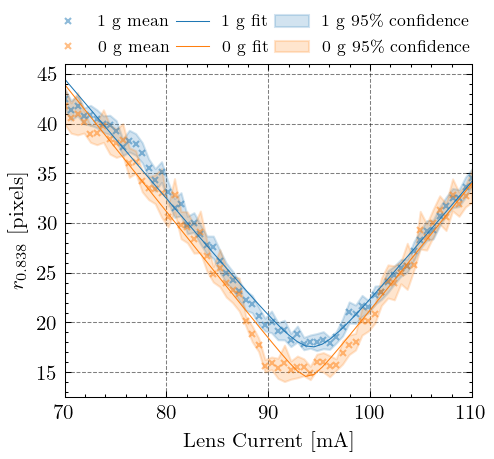

0.0006355582225038346


In [171]:
def hyperb(x, a, b, c, d):
    return a + np.sqrt(b + d * np.square(x-c))
    
# do a curve fit...
cmds_0g = np.array([x[0] for x in spots_0g])
sqarea_0g = np.array([x[1] for x in spots_0g])

cmds_hg = np.array([x[0] for x in spots_hg])
sqarea_hg = np.array([x[1] for x in spots_hg])

cmds_1g = np.array([x[0] for x in spots_1g])
sqarea_1g = np.array([x[1] for x in spots_1g])
# print(hyperb(cmds_0g, 1, 1, 1))
# print(cmds_0g.shape)
# print(sqarea_0g.shape)
popt_0g, pcov_0g = curve_fit(hyperb, cmds_0g, sqarea_0g, p0=[15, 1, 95, 2.5])
popt_hg, pcov_hg = curve_fit(hyperb, cmds_hg, sqarea_hg, p0=[15, 1, 95, 2.5])
popt_1g, pcov_1g = curve_fit(hyperb, cmds_1g, sqarea_1g, p0=[15, 1, 95, 2.5])

plt.figure(figsize=(3.5, 3.25))
linsp = np.linspace(70, 110)
plt.plot(focal_cmds, spot_mean_1g, 'x', alpha=0.5, color="tab:blue",markersize=2.5)
plt.plot(focal_cmds, spot_mean_0g, 'x', alpha=0.5, color="tab:orange",markersize=2.5)
# plt.plot(focal_cmds, spot_mean_hg, 'x', alpha=0.5)

# plt.plot(linsp, hyperb(linsp, 15, 1, 95, 1))
plt.plot(linsp, hyperb(linsp, *popt_1g), color="tab:blue")
plt.plot(linsp, hyperb(linsp, *popt_0g), color="tab:orange")
# plt.plot(linsp, hyperb(linsp, *popt_hg), color="tab:green")

print(np.sqrt(np.diag(pcov_0g)))
print(np.sqrt(np.diag(pcov_1g)))
print(np.sqrt(np.diag(pcov_hg)))

print(popt_0g)
print(popt_1g)
print(popt_hg)

# plt.plot(focal_cmds,(spot_mean_1g), 'x')
plt.fill_between(focal_cmds, (spot_mean_1g + spot_95_1g), (spot_mean_1g - spot_95_1g), alpha=0.2, color="tab:blue")
# plt.plot(focal_cmds, (spot_mean_0g), 'x')
plt.fill_between(focal_cmds, (spot_mean_0g + spot_95_0g), (spot_mean_0g - spot_95_0g), alpha=0.2, color="tab:orange")
# plt.plot(focal_cmds, (spot_mean_hg), 'x')
# plt.fill_between(focal_cmds, (spot_mean_hg + spot_sd_hg), (spot_mean_hg - spot_sd_hg), alpha=0.2)
plt.tight_layout()
# plt.grid()
plt.xlim(70, 110)

plt.xlabel("Lens Current [mA]")
plt.ylabel("$r_{0.838}$ [pixels]")
plt.legend(["1 g mean", "0 g mean", "1 g fit", "0 g fit", "1 g 95\% confidence", "0 g 95\% confidence"], loc='lower left', bbox_to_anchor=(-0.07, 0.98, 1.1, 0.1), ncol=3, mode="expand", fontsize=8,frameon=False)
plt.tight_layout()
plt.savefig("r_spot_optotune.pdf")           
plt.show()

# Obtain standard errors for both datasets
perr_0g = np.sqrt(np.diag(pcov_0g))
perr_1g = np.sqrt(np.diag(pcov_1g))

# Compute the t-statistic for the first parameter (e.g., slope)
t_statistic = (popt_0g[2] - popt_1g[2]) / np.sqrt(perr_0g[2]**2 + perr_1g[2]**2)

df_0g = len(cmds_0g) - len(popt_0g)
df_1g = len(cmds_1g) - len(popt_1g)
df = df_0g + df_1g - 2  # For two independent samples

# Compute the p-value
if t_statistic > 0:
    p_value = 2 * (1 - t.cdf(t_statistic, df))
else:
    p_value = 2 * t.cdf(t_statistic, df)

print(p_value)

In [175]:
# Calculate the standard deviation of the difference
sigma_diff = np.sqrt(perr_1g[2]**2 + perr_0g[2]**2)

# Calculate the difference between the third parameters
diff = popt_1g[2] - popt_0g[2]
print(popt_1g[2] - popt_0g[2])
# Calculate the 95% confidence interval
z = 1.96
conf_interval = z * sigma_diff

lower_bound = diff - conf_interval
upper_bound = diff + conf_interval

print(f"95% CI for the difference: ({lower_bound:.4f}, {upper_bound:.4f}) on {popt_1g[2]} with diff {diff}")

0.39985913042524146
95% CI for the difference: (0.1705, 0.6292) on 94.28384532800378 with diff 0.39985913042524146


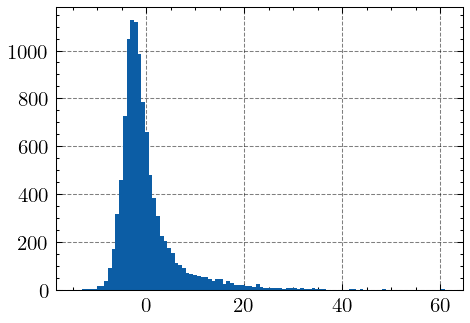

In [150]:
# Compute predicted values and residuals
y_pred = hyperb(cmds_1g, *popt_1g)
residuals = (sqarea_1g - y_pred)

plt.hist(residuals, bins=100)
plt.show()

78.1112304891765


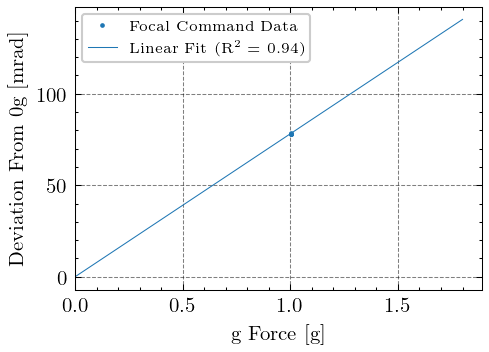

In [77]:
focal_samples = [x for x in samples if x.command == focal_cmd]

data_regress = [np.array([x.a for x in focal_samples]) , np.array([1000 * (com_0g[0] - ndimage.measurements.center_of_mass(ndimage.rotate(x.load_thresholded(), 23.6 + 180))[0]) * (2 * 2.2e-6) / (L) for x in focal_samples])]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_regress[0], data_regress[1])

bias = -intercept
print(slope)
# residual calculations

# plt.figure(figsize=(3.5, 3.25))
plt.plot(data_regress[0], data_regress[1] + bias, '.', markersize=2.5, alpha=1, color='tab:blue')
plt.plot([0, 1.8], [intercept + bias, intercept + bias + slope * 1.8], color='tab:blue')
plt.legend(["Focal Command Data", f"Linear Fit (R$^2$ = {r_value**2:.2f})"], fontsize='x-small')
plt.xlim(0)
plt.xlabel("g Force [g]")
plt.ylabel("Deviation From 0g [mrad]")
plt.savefig("optotune_regression.pdf")
plt.show()

In [80]:

y_pred = data_regress[0] * slope
residuals = data_regress[1] - y_pred
print(f"sd of residuals: {np.std(residuals)}")
print(data_regress[1])
print(f"sd of data {np.std(data_regress[1])}")

sd of residuals: 0.004990255071692189
[-0.08099411 -0.1021015  -0.10198006 -0.12351859 -0.13776746]
sd of data 0.019591752855015673


In [169]:
# Number of data points
n = len(data_regress[0])

# Degrees of freedom
df = n - 2

# t-critical value for 95% confidence
alpha = 0.05
t_crit = scipy.stats.t.ppf(1 - alpha/2, df)

# Compute 95% confidence interval for slope
ci_lower = slope - t_crit * std_err
ci_upper = slope + t_crit * std_err

print(f"95% CI for slope: ({ci_lower}, {ci_upper}), pm {t_crit * std_err}")

95% CI for slope: (4.131047053769242, 4.268163289370925), pm 0.06855811780084166


In [ ]:
t = [x.time for x in samples]
plt.hist(np.diff(t[1000::]), density=True, bins=50)
plt.tight_layout()
# plt.ylim(-0.2, 0.2)
plt.show()
# plt.plot([x.pressure for x in samples][1000::])

In [ ]:
# samples per command point
sample_counts = [len([y for y in samples_1g if y.command == c]) for c in focal_cmds]

# plt.bar(focal_cmds, sample_counts)
plt.plot(focal_cmds, np.sqrt(spot_mean_1g))
plt.tight_layout()
plt.grid()
plt.xlim(70, 110)
plt.show()


In [ ]:
# temperature drift vs spot size...
plt.plot([x.temperature for x in focal_samples_1g], [np.sqrt(x.spot_area()) for x in focal_samples_1g], 'x')
plt.plot([x.temperature for x in focal_samples_0g], [np.sqrt(x.spot_area()) for x in focal_samples_0g], 'x')
plt.plot([x.temperature for x in focal_samples_hg], [np.sqrt(x.spot_area()) for x in focal_samples_hg], 'x')
plt.grid()
plt.show()

In [ ]:
plt.hist([x.temperature for x in samples_1g], bins=np.arange(26, 36, 1), density=True, color='tab:blue')
plt.grid()
plt.ylim([0, 0.75])
plt.xlabel("Temperature [°C]")
plt.ylabel("Proportion [-]")
plt.tight_layout()
plt.savefig("optotune_temp_histogram_1g.pdf")
plt.show()
plt.hist([x.temperature for x in samples_0g], bins=np.arange(26, 36, 1), density=True, color='tab:orange')
plt.grid()
plt.ylim([0, 0.75])
plt.xlabel("Temperature [°C]")
plt.ylabel("Proportion [-]")
plt.tight_layout()
plt.savefig("optotune_temp_histogram_0g.pdf")
plt.show()
plt.hist([x.temperature for x in samples_hg],bins=np.arange(26, 36, 1), density=True, color='tab:green')
plt.grid()
plt.ylim([0, 0.5])
plt.xlabel("Temperature [°C]")
plt.ylabel("Proportion [-]")
plt.show()

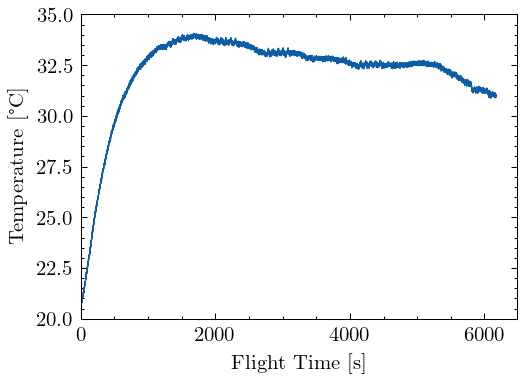

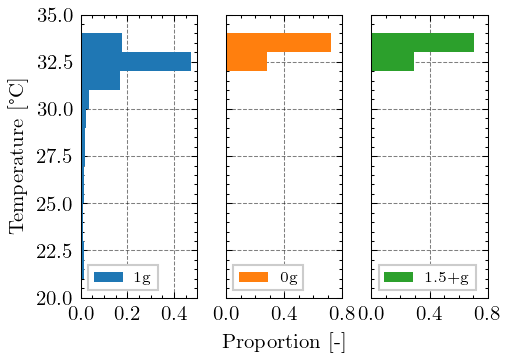

In [19]:
plt.plot([x.time - t0 for x in samples], [x.temperature for x in samples])
# plt.plot([x.time - t0 for x in samples_1g], [x.temperature for x in samples_1g], '.')
# plt.plot([x.time - t0 for x in samples_hg], [x.temperature for x in samples_hg], '.')
# plt.plot(np.load("time_optotune.npy"), np.load("temp_optotune.npy"))
plt.tight_layout()
# plt.legend(["Corning Varioptic", "Optotune"], loc='lower right')
plt.grid()
plt.ylabel("Temperature [°C]")
plt.xlabel("Flight Time [s]")
plt.xlim(0)
plt.ylim(20, 35)
plt.savefig('temperature_opto.pdf')  
plt.show()

plt.subplots(1,3, constrained_layout=False)
plt.subplot(1, 3, 1)
plt.hist([x.temperature for x in samples_1g], bins=np.arange(20, 36, 1), density=True, color='tab:blue', orientation="horizontal")
# plt.grid()
plt.ylim([20, 35])
plt.ylabel("Temperature [°C]")
# plt.xlabel("Proportion [-]")
plt.legend(["1g"], loc='lower left', fancybox=False, fontsize="x-small")
plt.xticks([0, 0.2, 0.4])
# plt.tight_layout()
# plt.savefig("corning_temp_histogram_1g.pdf")
plt.subplot(1, 3, 2)
plt.hist([x.temperature for x in samples_0g], bins=np.arange(20, 36, 1), density=True, color='tab:orange', orientation="horizontal")
# plt.grid()
plt.ylim([20, 35])
# plt.ylabel("Temperature [°C]")
plt.xlabel("Proportion [-]")
plt.legend(["0g"], loc='lower left', fancybox=False, fontsize="x-small")
plt.xticks([0, 0.4, 0.8])
frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.subplot(1, 3, 3)
plt.hist([x.temperature for x in samples_hg], bins=np.arange(20, 36, 1), density=True, color='tab:green', orientation="horizontal")
# plt.grid()
plt.ylim([20, 35])
# plt.ylabel("Temperature [°C]")
# plt.xlabel("Proportion [-]")
plt.legend(["1.5+g"], loc='lower left', fancybox=False, fontsize="x-small")
plt.xticks([0, 0.4, 0.8])
frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.subplots_adjust(wspace=0.25)
plt.savefig("temp_histo_opto.pdf")
plt.show()
# plt.hist([x.temperature for x in samples_0g], bins=np.arange(26, 32.5, 1), density=True, color='tab:orange')
# plt.grid()
# plt.ylim([0, 0.5])
# plt.xlabel("Temperature [°C]")
# plt.ylabel("Proportion [-]")
# plt.tight_layout()
# plt.savefig("corning_temp_histogram_0g.pdf")
# plt.show()
# plt.hist([x.temperature for x in samples_hg],bins=np.arange(26, 32.5, 1), density=True, color='tab:green')
# plt.tight_layout()
# plt.grid()
# plt.ylim([0, 0.5])
# plt.xlabel("Temperature [°C]")
# plt.ylabel("Proportion [-]")
# plt.show()

In [50]:
spot_sample = focal_samples_hg[5]
spot_img = spot_sample.load()
spot_img = ndimage.rotate(spot_img, 23.6 + 180) # rotate into vertical axes (measured from experiment)

spot_img_threshold = spot_img.copy()
spot_img_threshold[spot_img_threshold <= 8] = 0 # tiny threshold to avoid far-away noise residuals

def gaussian_2d(params, x, y):
    amplitude, x0, y0, d_major, d_minor, theta = params
    sigma_major = d_major / (2 * np.sqrt(2 * np.log(2)))
    sigma_minor = d_minor / (2 * np.sqrt(2 * np.log(2)))
    
    theta = np.deg2rad(theta)  # Convert rotation angle from degrees to radians
    a = (np.cos(theta)**2) / (2*sigma_major**2) + (np.sin(theta)**2) / (2*sigma_minor**2)
    b = -np.sin(2*theta) / (4*sigma_major**2) + np.sin(2*theta) / (4*sigma_minor**2)
    c = (np.sin(theta)**2) / (2*sigma_major**2) + (np.cos(theta)**2) / (2*sigma_minor**2)
    
    g = amplitude * np.exp( - (a*(x-x0)**2 + 2*b*(x-x0)*(y-y0) + c*(y-y0)**2))
    return g.ravel()

def fit_gaussian_2d(data):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    
    # Initial guess for amplitude, x0, y0, d_major, d_minor, theta
    initial_guess = (data.max(), data.shape[1]/2, data.shape[0]/2, data.shape[1]/2, data.shape[0]/2, 0)
    
    return curve_fit(lambda p, a, x0, y0, d_major, d_minor, theta: gaussian_2d([a, x0, y0, d_major, d_minor, theta], p, y), x, data.ravel(), p0=initial_guess)

fit_params, fit_cov = fit_gaussian_2d(spot_img_threshold)
print(fit_params)


[ 319.6080947   650.89167163  436.11253152  -15.40735709   37.01078982
 -216.2721355 ]


22.911675876137934
Centroid (x, y): (650.9045459284746, 436.98066937754146)


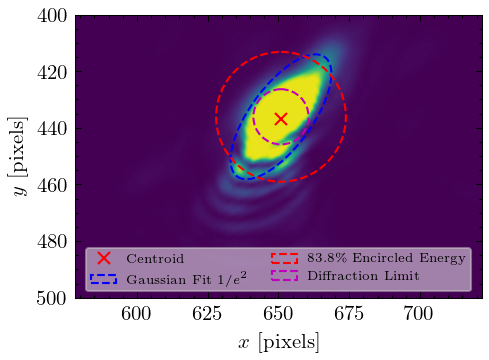

In [61]:
centroid_y0, centroid_x0, _ = ndimage.center_of_mass(spot_img_threshold)
airy_radius = spot_sample.airy_encircled_energy(img_thresh=0.025)
print(airy_radius)
efl = 136e-3
print(f"Centroid (x, y): ({centroid_x0}, {centroid_y0})")

def plot_gaussian_contour(data, params):
    amplitude, x0, y0, d_major, d_minor, theta = params
    ax = plt.gca()
    
      # 1/e^2 radius is used to represent the Gaussian width.
    width = d_major * np.sqrt(-2 * np.log(1/np.e))
    height = d_minor * np.sqrt(-2 * np.log(1/np.e))
    
    ellipse = matplotlib.patches.Ellipse((x0, y0), width, height, angle=-theta, edgecolor='blue', facecolor='none', linestyle='dashed')
    ax.add_patch(ellipse)


# plt.figure(figsize=(6, 4))
plt.axis("equal")
plt.plot(centroid_x0, centroid_y0, 'rx')
plot_gaussian_contour(spot_img, fit_params)
plot_airy_encircled_energy(spot_img, fit_params[1], fit_params[2], airy_radius)
plot_diffraction_limit(spot_img, fit_params[1], fit_params[2])
plt.imshow(spot_img/np.max(spot_img),interpolation='bicubic')
plt.axis('equal')
# plt.yticks([])
plt.legend(["Centroid", "Gaussian Fit 1/$e^2$", "83.8\% Encircled Energy", "Diffraction Limit"],fontsize=6,framealpha=0.5, ncol=2, loc="lower center")
plt.xlim(620, 680)
plt.ylim(500, 400)
plt.grid()
plt.xlabel("$x$ [pixels]")
plt.ylabel("$y$ [pixels]")
plt.savefig("spot_fit_comparison.pdf")
plt.show()